# Regression discontinuity with sci-kit learn models

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel
from sklearn.linear_model import LinearRegression

import causalpy as cp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'

## Load data

In [3]:
data = cp.load_data("rd")
data.head()

,x,y,treated
0,-0.932739,-0.091919,False
1,-0.930778,-0.382663,False
2,-0.929110,-0.181786,False
3,-0.907419,-0.288245,False
4,-0.882469,-0.420811,False


## Linear, main-effects model

In [4]:
result = cp.skl_experiments.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

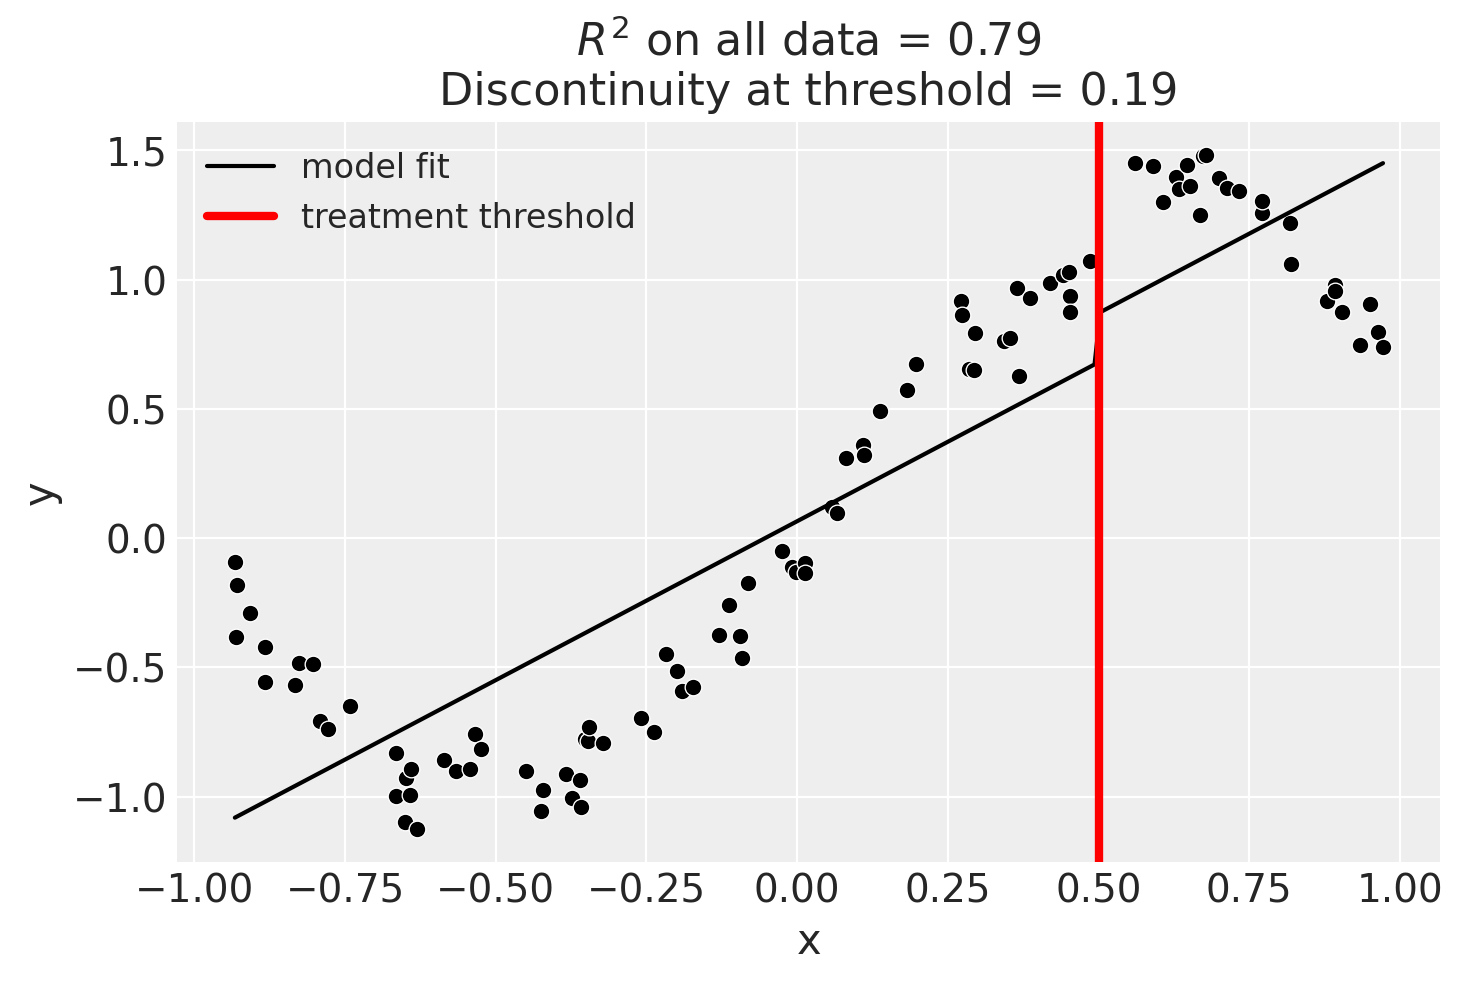

In [5]:
fig, ax = result.plot()

## Linear, main-effects, and interaction model

In [6]:
result = cp.skl_experiments.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

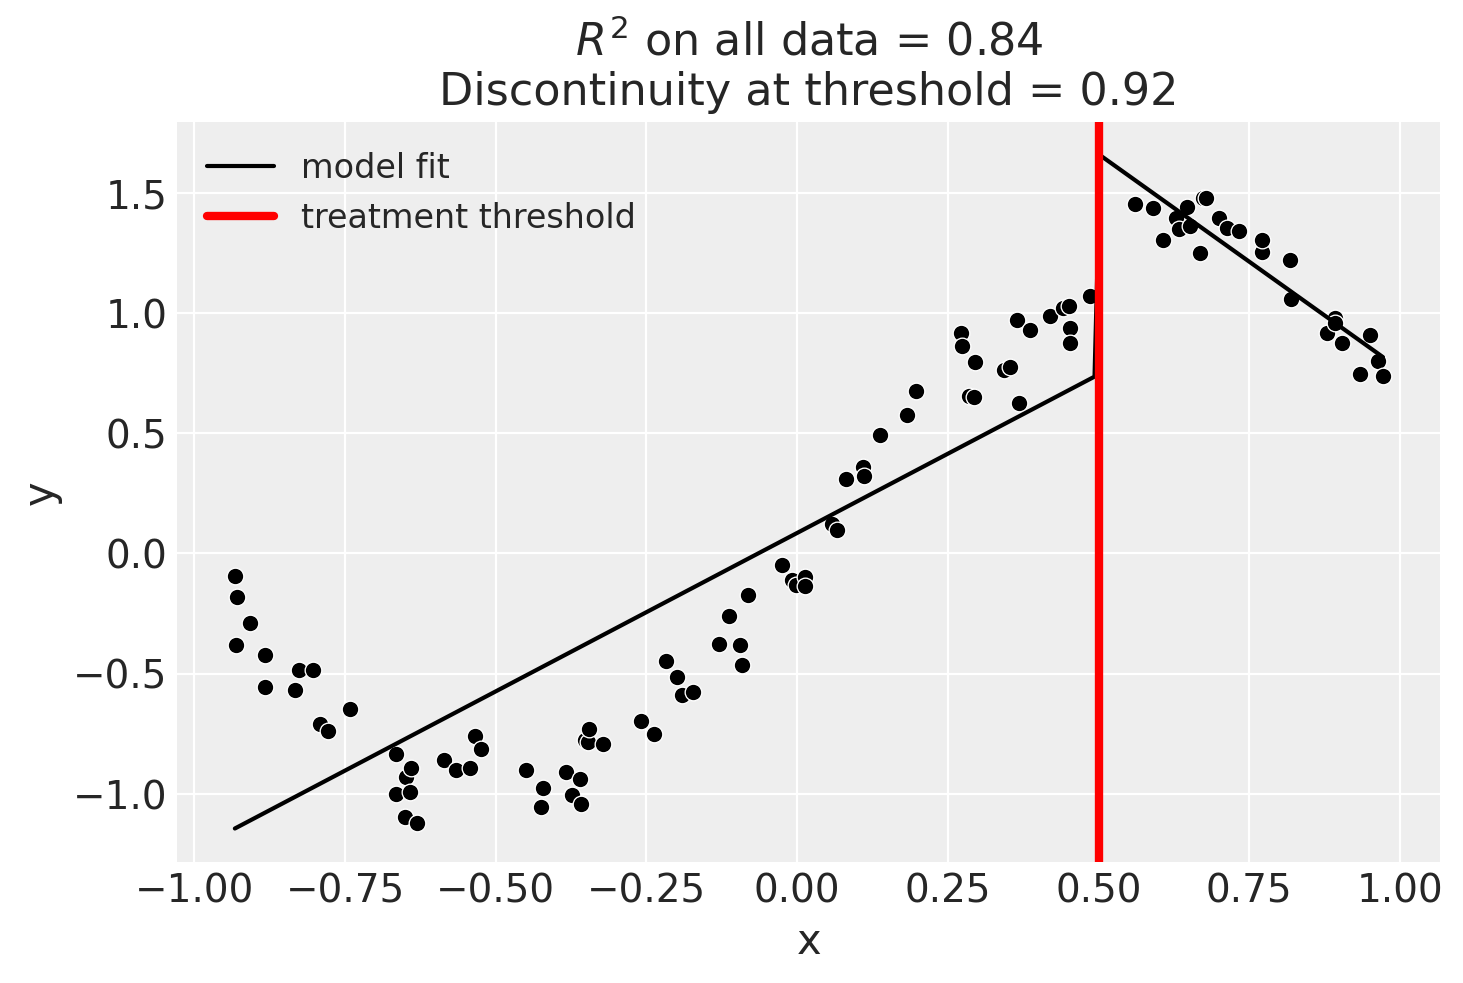

In [7]:
result.plot();

Though we can see that this does not give a good fit of the data almost certainly overestimates the discontinuity at threshold.

## Using a bandwidth

One way how we could deal with this is to use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the threshold. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

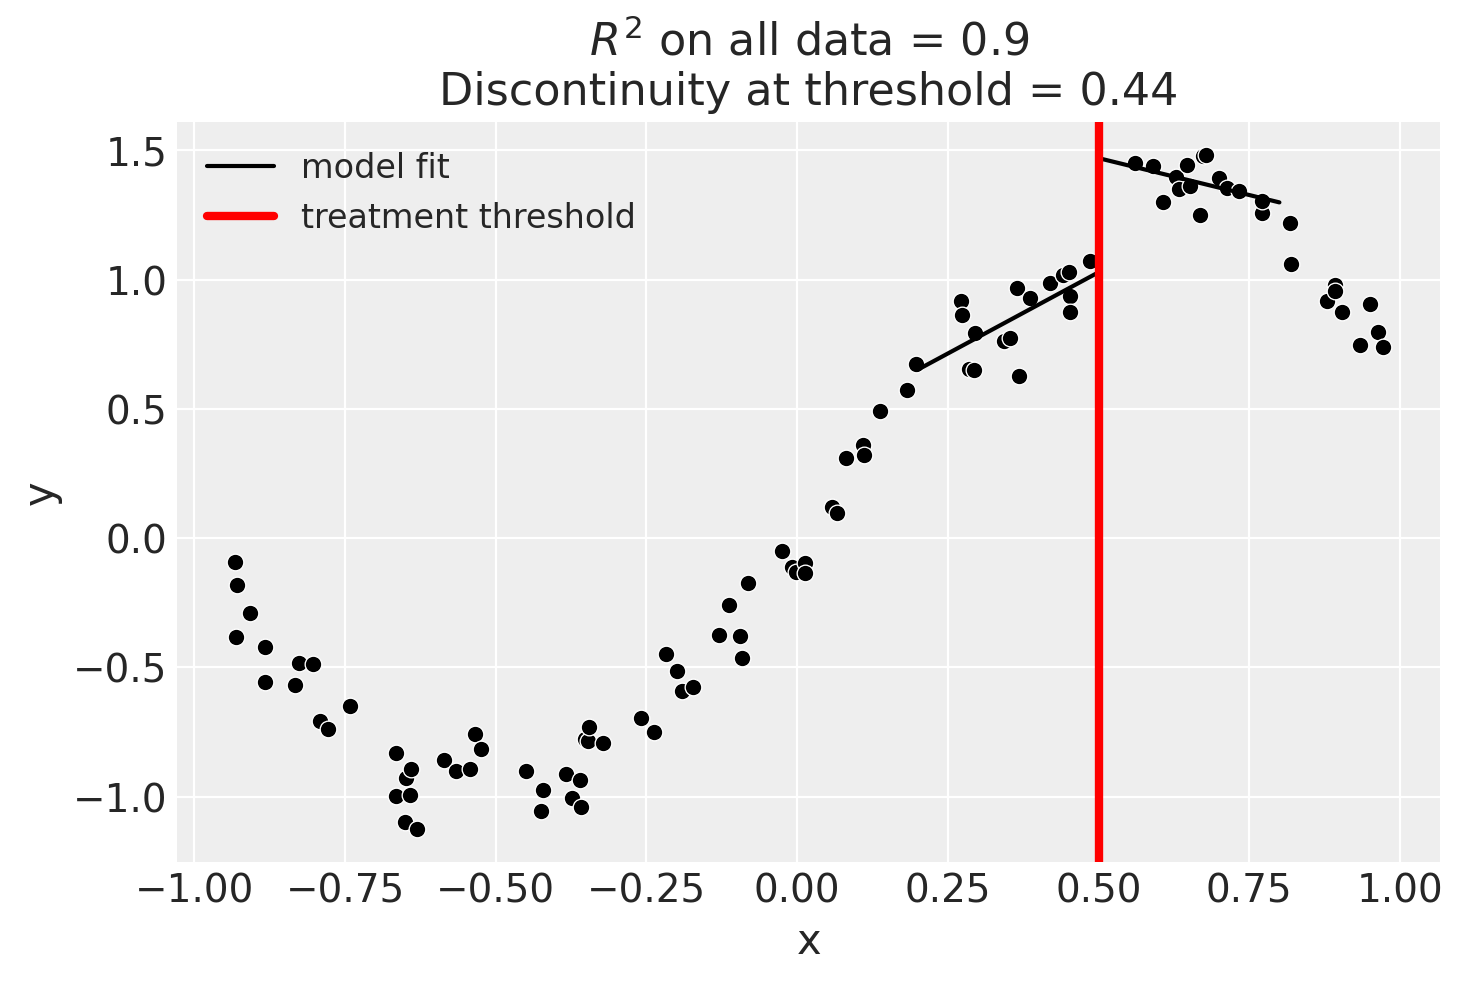

In [8]:
result = cp.skl_experiments.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

result.plot();

We could even go crazy and just fit intercepts for the data close to the threshold. But clearly this will involve more estimation error as we are using less data.

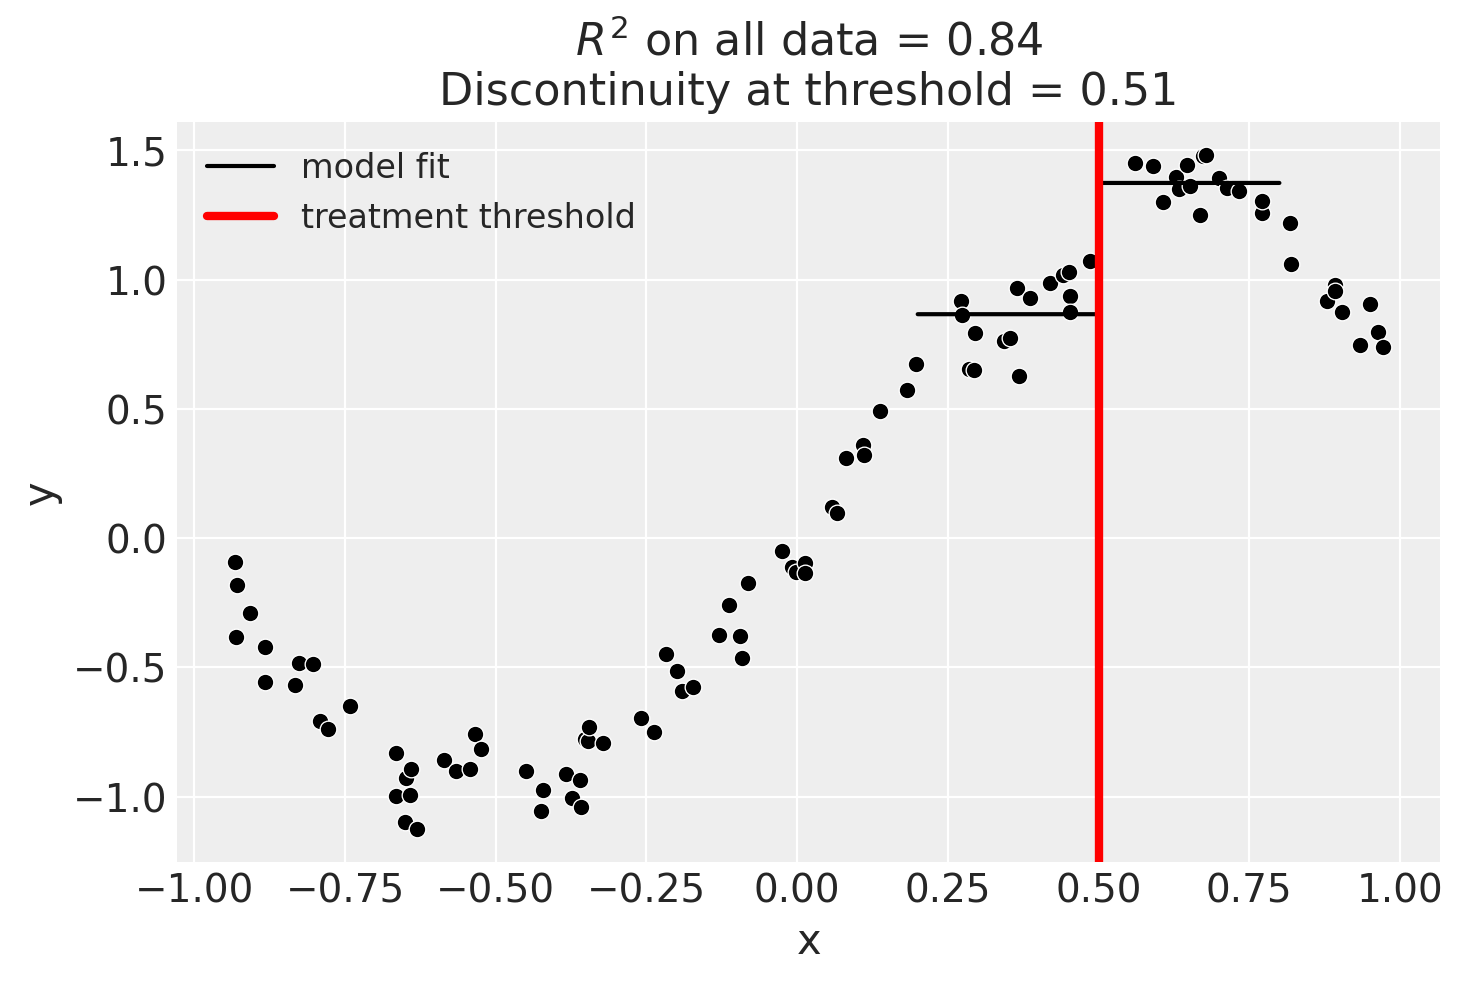

In [9]:
result = cp.skl_experiments.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

result.plot();

## Using Gaussian Processes

In [10]:
kernel = 1.0 * ExpSineSquared(1.0, 5.0) + WhiteKernel(1e-1)
result = cp.skl_experiments.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    model=GaussianProcessRegressor(kernel=kernel),
    treatment_threshold=0.5,
)

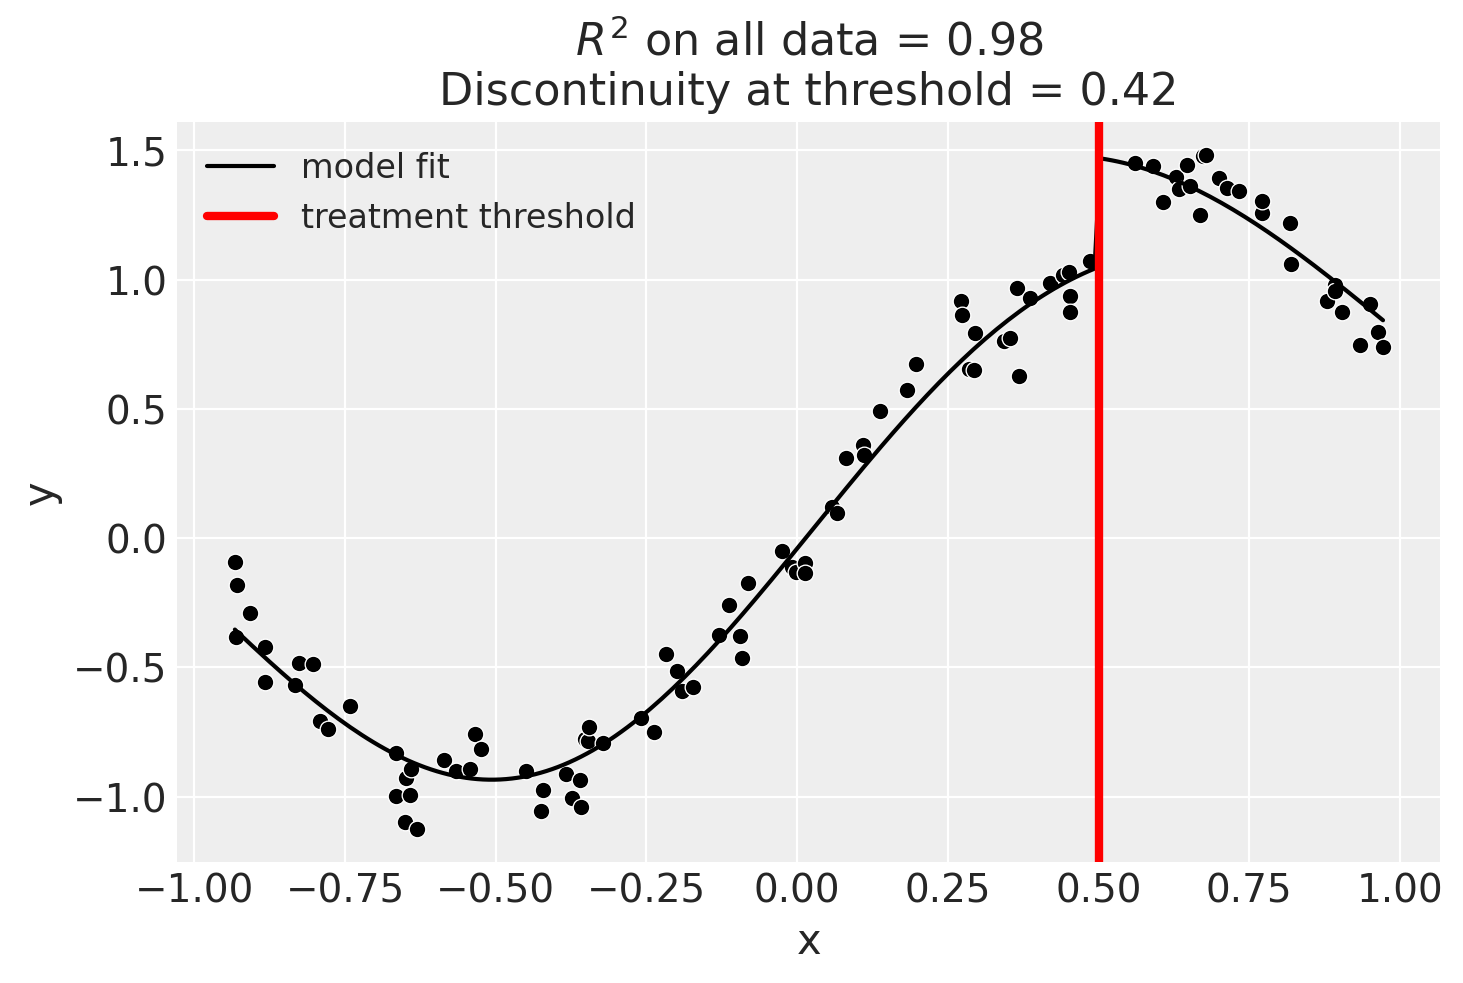

In [11]:
fig, ax = result.plot()

## Using basis splines

In [12]:
result = cp.skl_experiments.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=LinearRegression(),
    treatment_threshold=0.5,
)

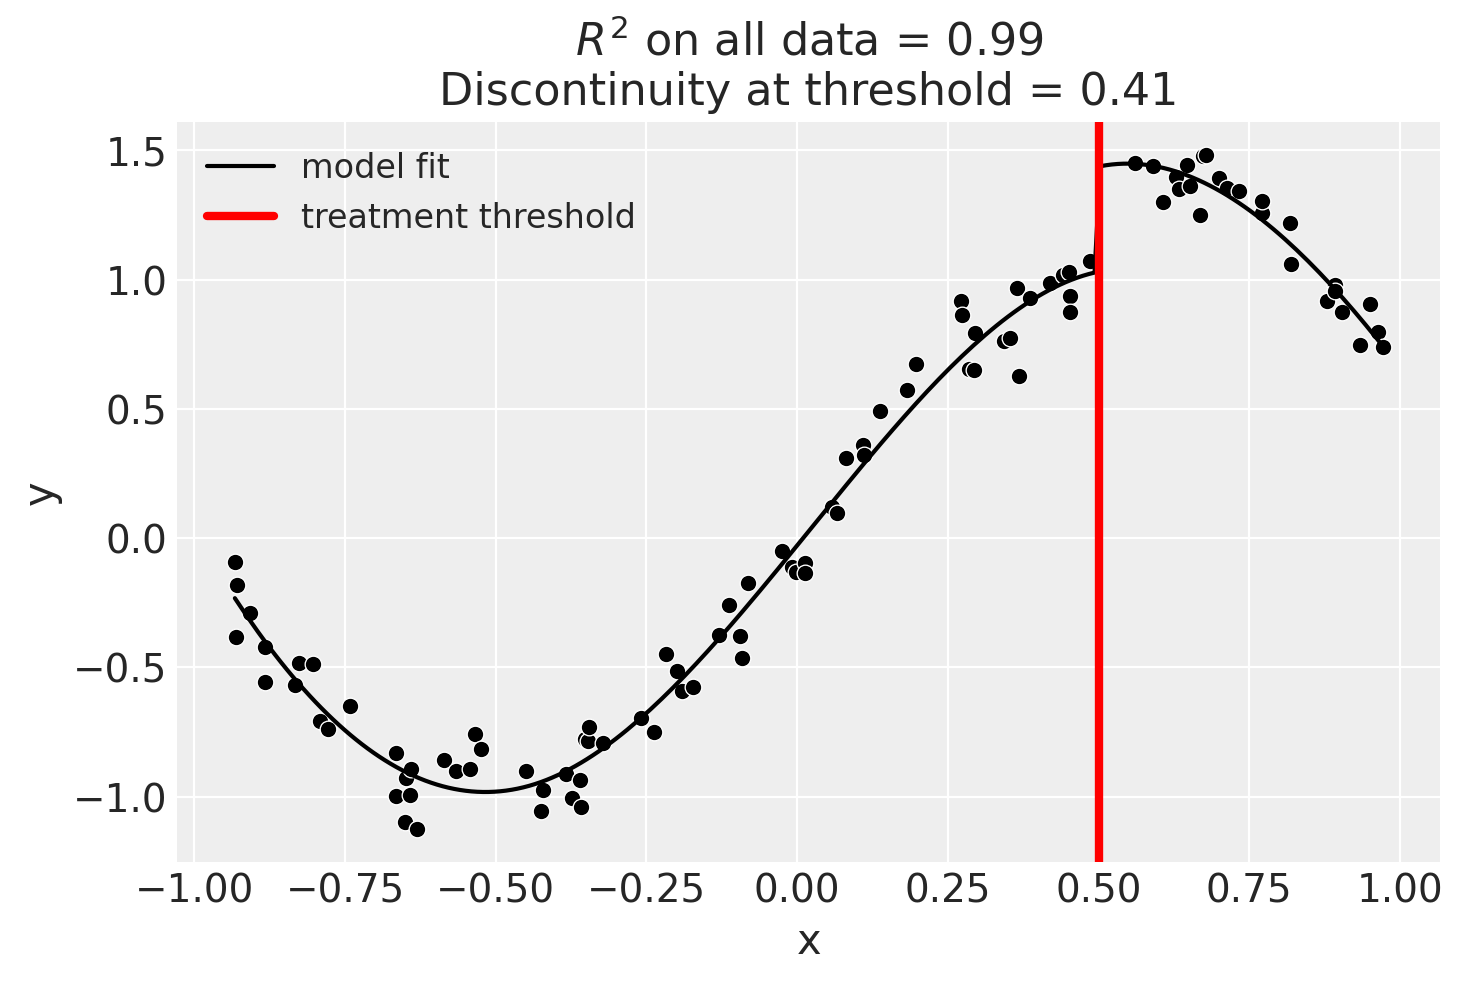

In [13]:
fig, ax = result.plot()